# CSE252D: Homework 3
## Computing Resources
Please read the README file of this repository for the instructions
## Instructions
1. Attempt all questions.
2. Please comment all your code adequately.
3. Include all relevant information such as text answers, output images in notebook.
4. **Academic integrity:** The homework must be completed individually.

5. **Submission instructions:**  
 (a) Submit the notebook and its PDF version on Gradescope.  
 (b) Rename your submission files as Lastname_Firstname.ipynb and Lastname_Firstname.pdf.  
 (c) Correctly select pages for each answer on Gradescope to allow proper grading.

6. **Due date:** Sun, Jun 6, at 11:59pm.

## Q1: UNet for Image Segmentation

1. **Check the codes in `Segmentation`.** In this homework, we will provide the dataset loader, the evaluation code, the basic UNet structure and some useful functions. You will be asked to try different variations of network structure and decide the best training strategies to obtain good results. Like in previous homeworks, you are welcome to cite any open source codes that help you improve performance. The provided codes include:
    1. `test.py`: The file for evaluation. 
    2. `dataLoader.py`: The file to load the data for training and testing.  
    3. `model.py`: The file for models. The residual block (`ResBlock`) and the code to load pretrained weights of `resnet18  loadPretrainedWeight`) are given. The basic encoder and decoder are also given as a reference. 
    4. `colormap.mat`: The color map used to visualize segmentation results. 
    5. `utils.py`: The file for two useful functions. The `computeAccuracy` function computes the unnormalized confusion matrix of each batch of labels. The `save\_label` function turns the label into an image using the given color map and saves the image at the assigned location. Also see `test.py` for how these two functions are being used. 
    6. `train.py`: An empty file where you will implement your training script. 

2. **Implement the network structures.**  You are required to implement 2 versions of UNet structure since the basic structure has already been given. In all three versions,  the `resnet18` structure before average pooling and fully connected layer will be used as the building block for encoder. You are strongly recommended to use weights pretrained on ImageNet, which may have a major impact on the performance. 
    1. `Basic UNet`: The code is given as a reference. Please see `encoder` and `decoder` class in `model.py`. The `encoder` comes from `resnet18` and the decoder consists of transpose convolutional layers and bilinear interpolation layers so that the final output will be of the same size as the image. Skip links are added to help the network recover more details. Please do not change the encoder. However, you are free to change the decoder, while ensuring that the structure of your decoder across three versions of the networks are similar so that you can make a fair comparison of their performances. 
    2. `UNet with dilation`: We modify the encoder to a dilated `resnet18` as described in Section 2 of [1] (You are not required to consider degridding in Section 4 of [1] ). We set the stride of the last 4 residual blocks to be 1 so that the highest level feature maps will be $4\times 4$ times larger. To increase the receptive field, we set the dilation of residual blocks that are fourth and third from the end to be 2, while the dilation of the residual blocks that are first and second from the end are set to 4.  The decoder should be modified accordingly. Implement your new encoder and decoder under class `encoderDilation` and `decoderDilation`. Ensure that for images of arbitrary shapes, the decoder will give segmentation outputs of the same shape.  **[15 points]**
    3. `UNet with dilation and pyramid pooling`:  Based on the encoder-decoder structure with dilation, add pyramid pooling layer after the last residual block of encoder.  Implement the pyramid pooling layer following [2]. Notice that after adding the pyramid layer, the number of channels of the output feature to the first transpose convolutional layer will change from 512 to 1024. Please implement your new encoder and decoder under classes `encoderSPP` and `decoderSPP`, respectively.  **[15 points]**

```python
class encoderDilation(nn.Module):
    def __init__(self):
        super(encoderDilation, self).__init__()

        # IMPLEMENT YOUR CODE HERE
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.b1_1 = ResBlock(64, 64, 1)
        self.b1_2 = ResBlock(64, 64, 1)

        self.b2_1 = ResBlock(64, 128, 2)
        self.b2_2 = ResBlock(128, 128, 1)

        self.b3_1 = ResBlock(128, 256, 1, 2)
        self.b3_2 = ResBlock(256, 256, 1, 2)

        self.b4_1 = ResBlock(256, 512, 1, 4)
        self.b4_2 = ResBlock(512, 512, 1, 4)

    def forward(self, im):

        # IMPLEMENT YOUR CODE HERE
        x1 = F.relu(self.bn1(self.conv1(im)), inplace=True)
        x2 = self.b1_2(self.b1_1(self.maxpool(x1)))
        x3 = self.b2_2(self.b2_1(x2))
        x4 = self.b3_2(self.b3_1(x3))
        x5 = self.b4_2(self.b4_1(x4))
        return x1, x2, x3, x4, x5


class decoderDilation(nn.Module):
    def __init__(self, isSpp=False):
        super(decoderDilation, self).__init__()

        # IMPLEMENT YOUR CODE HERE
        self.conv1 = nn.Conv2d(512+256+128, 512, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(512)
        self.conv1_1 = nn.Conv2d(512, 21, 3, 1, 1, bias=False)
        self.bn1_1 = nn.BatchNorm2d(21)
        self.conv2 = nn.Conv2d(64+21, 21, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(21)
        self.conv3 = nn.Conv2d(21, 21, 3, 1, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(21)
        self.conv4 = nn.Conv2d(21, 21, 3, 1, 1, bias=False)
        self.sf = nn.Softmax(dim=1)

    def forward(self, im, x1, x2, x3, x4, x5):

        # IMPLEMENT YOUR CODE HERE
        _, _, nh, nw = x3.size()
        x5 = F.interpolate(x5, [nh, nw], mode='bilinear')
        x4 = F.interpolate(x4, [nh, nw], mode='bilinear')
        y1 = F.relu(
            self.bn1(self.conv1(torch.cat([x3, x4, x5], dim=1))), inplace=True)
        y1 = F.relu(self.bn1_1(self.conv1_1(y1)), inplace=True)

        _, _, nh, nw = x2.size()
        y1 = F.interpolate(y1, [nh, nw], mode='bilinear')
        y1 = torch.cat([y1, x2], dim=1)
        y2 = F.relu(self.bn2(self.conv2(y1)), inplace=True)

        _, _, nh, nw = x1.size()
        y2 = F.interpolate(y2, [nh, nw], mode='bilinear')
        y3 = F.relu(self.bn3(self.conv3(y2)), inplace=True)

        y4 = self.sf(self.conv4(y3))

        _, _, nh, nw = im.size()
        y4 = F.interpolate(y4, [nh, nw], mode='bilinear')

        pred = -torch.log(torch.clamp(y4, min=1e-8))

        return pred

```

```python
class encoderSPP(nn.Module):
    def __init__(self):
        super(encoderSPP, self).__init__()

        # IMPLEMENT YOUR CODE HERE
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.b1_1 = ResBlock(64, 64, 1)
        self.b1_2 = ResBlock(64, 64, 1)

        self.b2_1 = ResBlock(64, 128, 2)
        self.b2_2 = ResBlock(128, 128, 1)

        self.b3_1 = ResBlock(128, 256, 1, 2)
        self.b3_2 = ResBlock(256, 256, 1, 2)

        self.b4_1 = ResBlock(256, 512, 1, 4)
        self.b4_2 = ResBlock(512, 512, 1, 4)

        bins = (1,2,3,6)
        self.ppm = PPM(512, int(512/len(bins)), bins)

    def forward(self, im):

        # IMPLEMENT YOUR CODE HERE
        x1 = F.relu(self.bn1(self.conv1(im)), inplace=True)
        x2 = self.b1_2(self.b1_1(self.maxpool(x1)))
        x3 = self.b2_2(self.b2_1(x2))
        x4 = self.b3_2(self.b3_1(x3))
        x5 = self.b4_2(self.b4_1(x4))
        x5 = self.ppm(x5)
        return x1, x2, x3, x4, x5


class decoderSPP(nn.Module):
    def __init__(self, isSpp=False):
        super(decoderSPP, self).__init__()

        # IMPLEMENT YOUR CODE HERE
        self.conv1 = nn.Conv2d(1024+256+128, 512, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(512)
        self.conv1_1 = nn.Conv2d(512, 21, 3, 1, 1, bias=False)
        self.bn1_1 = nn.BatchNorm2d(21)
        self.conv2 = nn.Conv2d(64+21, 21, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(21)
        self.conv3 = nn.Conv2d(21, 21, 3, 1, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(21)
        self.conv4 = nn.Conv2d(21, 21, 3, 1, 1, bias=False)
        self.sf = nn.Softmax(dim=1)

    def forward(self, im, x1, x2, x3, x4, x5):

        # IMPLEMENT YOUR CODE HERE
        _, _, nh, nw = x3.size()
        x5 = F.interpolate(x5, [nh, nw], mode='bilinear')
        x4 = F.interpolate(x4, [nh, nw], mode='bilinear')
        y1 = F.relu(
            self.bn1(self.conv1(torch.cat([x3, x4, x5], dim=1))), inplace=True)
        y1 = F.relu(self.bn1_1(self.conv1_1(y1)), inplace=True)

        _, _, nh, nw = x2.size()
        y1 = F.interpolate(y1, [nh, nw], mode='bilinear')
        y1 = torch.cat([y1, x2], dim=1)
        y2 = F.relu(self.bn2(self.conv2(y1)), inplace=True)

        _, _, nh, nw = x1.size()
        y2 = F.interpolate(y2, [nh, nw], mode='bilinear')
        y3 = F.relu(self.bn3(self.conv3(y2)), inplace=True)

        y4 = self.sf(self.conv4(y3))

        _, _, nh, nw = im.size()
        y4 = F.interpolate(y4, [nh, nw], mode='bilinear')

        pred = -torch.log(torch.clamp(y4, min=1e-8))

        return pred

# From official implementation of SpyNet
class PPM(nn.Module):
    def __init__(self, in_dim, reduction_dim, bins):
        super(PPM, self).__init__()
        self.features = []
        for bin in bins:
            self.features.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(bin),
                nn.Conv2d(in_dim, reduction_dim, kernel_size=1, bias=False),
                nn.BatchNorm2d(reduction_dim),
                nn.ReLU(inplace=True)
            ))
        self.features = nn.ModuleList(self.features)

    def forward(self, x):
        x_size = x.size()
        out = [x]
        for f in self.features:
            out.append(F.interpolate(f(x), x_size[2:], mode='bilinear', align_corners=True))
        return torch.cat(out, 1)

```

3. **Implement training script and train the network.** Train your network using 1464 images from the training set of PASCAL VOC 2012. The dataset is on the server `/datasets/cs252-sp21-A00-public/hw3_data/VOCdevkit`. If you are not familiar with training scripts, you can refer to `test.py`  in this homework and `casia_train.py` in the previous homework. The structures of the training script are very similar. Please remember to output the training loss and training accuracy which may help you find the best hyper parameters.  **[40 points]**
    1. To accelerate the training speed, you can use the Pytorch multi-threaded data loader. **Important:** if you use multi-threaded data loader, remember to either randomly shuffle the data or change the random seeds after every epoch. Otherwise you will have severe overfitting issues because the data loader will always crop the same region of the image. 
    2. It is recommended to compute the prediction mIoU every epoch, since the curve of mIoU can be very different from the inverse of loss function. It may help you find the best training strategy. 
    3. To overcome over-fitting issues, you are encouraged to adopt more aggressive data augmentation methods, such as flipping the images or changing the intensity. 
    4. There are many things that may influence performance, such as learning rate, batch size and network structure of encoder and decoder. It might be hard to achieve state-of-the-art results. **The grading of the homework will not focus on the final mean IoU but more on analysis.** So don't be too worried if you cannot get very good performance. Just make sure that you describe what you observe and answer the questions succinctly. 

Training script is implemented in `Segmentation/train.py`

**Code:**

```python
import torch
from model import loadPretrainedWeight
from torch.autograd import Variable
import torch.optim as optim
import torch.functional as F
import dataLoader
import argparse
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import model
import torch.nn as nn
import os
import numpy as np
import utils
import scipy.io as io
import warnings
warnings.filterwarnings('ignore')

parser = argparse.ArgumentParser()
# The location of training set
parser.add_argument(
    '--imageRoot', default='/datasets/cse152-252-sp20-public/hw3_data/VOCdevkit/VOC2012/JPEGImages', help='path to input images')
parser.add_argument(
    '--labelRoot', default='/datasets/cse152-252-sp20-public/hw3_data/VOCdevkit/VOC2012/SegmentationClass', help='path to input images')
parser.add_argument(
    '--fileList',
    default='/datasets/cse152-252-sp20-public/hw3_data/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt', help='path to input images')
parser.add_argument('--experiment', default='train',
                    help='the path to store sampled images and models')
parser.add_argument('--modelRoot', default='checkpoint',
                    help='the path to store the training results')
parser.add_argument('--initLR', type=float, default=0.1, help='the initial learning rate')
parser.add_argument('--nepoch', type=int, default=100, help='the training epoch')
parser.add_argument('--batchSize', type=int, default=32,
                    help='the size of a batch')
parser.add_argument('--numClasses', type=int, default=21,
                    help='the number of classes')
parser.add_argument('--isDilation', action='store_true',
                    help='whether to use dialated model or not')
parser.add_argument('--isSpp', action='store_true',
                    help='whether to do spatial pyramid or not')
parser.add_argument('--noCuda', action='store_true',
                    help='do not use cuda for training')
parser.add_argument('--gpuId', type=int, default=0,
                    help='gpu id used for training the network')
parser.add_argument('--colormap', default='colormap.mat',
                    help='colormap for visualization')

# The detail network setting
opt = parser.parse_args()
print(opt)

colormap = io.loadmat(opt.colormap)['cmap']

if opt.isSpp == True:
    opt.isDilation = False

if opt.isDilation:
    opt.experiment += '_dilation'
    opt.modelRoot += '_dilation'
if opt.isSpp:
    opt.experiment += '_spp'
    opt.modelRoot += '_spp'

# Save all the codes
os.system('mkdir %s' % opt.experiment)
os.system('cp *.py %s' % opt.experiment)

if torch.cuda.is_available() and opt.noCuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

# Initialize image batch
imBatch = Variable(torch.FloatTensor(opt.batchSize, 3, 300, 300))
labelBatch = Variable(torch.FloatTensor(
    opt.batchSize, opt.numClasses, 300, 300))
maskBatch = Variable(torch.FloatTensor(opt.batchSize, 1, 300, 300))
labelIndexBatch = Variable(torch.LongTensor(opt.batchSize, 1, 300, 300))

# Initialize network
if opt.isDilation:
    encoder = model.encoderDilation()
    decoder = model.decoderDilation()
elif opt.isSpp:
    encoder = model.encoderSPP()
    decoder = model.decoderSPP()
else:
    encoder = model.encoder()
    decoder = model.decoder()

# Move network and containers to gpu
if not opt.noCuda:
    device = 'cuda'
else:
    device = 'cpu'

imBatch = imBatch.to(device)
labelBatch = labelBatch.to(device)
labelIndexBatch = labelIndexBatch.to(device)
maskBatch = maskBatch.to(device)
encoder = encoder.to(device)
decoder = decoder.to(device)

# Load pre-trained weights
loadPretrainedWeight(encoder)

# Initialize optimizer
params = list(encoder.parameters()) + list(decoder.parameters())
# optimizer = optim.RMSprop(params, lr=opt.initLR, weight_decay=1e-8, momentum=0.9)
optimizer = optim.SGD(params, lr=opt.initLR, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Initialize dataLoader
segDataset = dataLoader.BatchLoader(
    imageRoot=opt.imageRoot,
    labelRoot=opt.labelRoot,
    fileList=opt.fileList,
    imWidth=300,
    imHeight=300
)
segLoader = DataLoader(segDataset, batch_size=opt.batchSize,
                       num_workers=4, shuffle=True)

lossArr = []
accuracyArr = []
iteration = 0
epoch = opt.nepoch
confcounts = np.zeros((opt.numClasses, opt.numClasses), dtype=np.int64)
accuracy = np.zeros(opt.numClasses, dtype=np.float32)
trainingLog = open(
    '{0}/trainingLog_{1}.txt'.format(opt.experiment, epoch), 'w')
for epoch in range(0, opt.nepoch):
    torch.cuda.manual_seed(epoch)
    trainingLog = open(
        '{0}/trainingLog_{1}.txt'.format(opt.experiment, epoch), 'w')
    for i, dataBatch in enumerate(segLoader):
        iteration += 1

        # Read data
        imBatch = Variable(dataBatch['im']).to(device)
        labelBatch = Variable(dataBatch['label']).to(device)
        labelIndexBatch = Variable(dataBatch['labelIndex']).to(device)
        maskBatch = Variable(dataBatch['mask']).to(device)

        # Train network
        optimizer.zero_grad()
        x1, x2, x3, x4, x5 = encoder(imBatch)
        pred = decoder(imBatch, x1, x2, x3, x4, x5)

        loss = torch.mean(pred * labelBatch)
        loss.backward()
        optimizer.step()

        # Compute mean IOU
        hist = utils.computeAccuracy(pred, labelIndexBatch, maskBatch)
        confcounts += hist

        for n in range(0, opt.numClasses):
            rowSum = np.sum(confcounts[n, :])
            colSum = np.sum(confcounts[:, n])
            interSum = confcounts[n, n]
            accuracy[n] = float(100.0 * interSum) / \
                max(float(rowSum + colSum - interSum), 1e-5)

        # Output the log information
        lossArr.append(loss.cpu().data.item())
        meanLoss = np.mean(np.array(lossArr[:]))
        meanAccuracy = np.mean(accuracy)
        accuracyArr.append(meanAccuracy)

        print('Epoch %d iteration %d: Loss %.5f Accumulated Loss %.5f'
              % (epoch, iteration, lossArr[-1], meanLoss))
        print('Epoch %d iteration %d: Accumulated Accuracy %.5f'
              % (epoch, iteration, meanAccuracy))
        trainingLog.write('Epoch %d iteration %d: Loss %.5f Accumulated Loss %.5f \n'
                          % (epoch, iteration, lossArr[-1], meanLoss))
        trainingLog.write('Epoch %d iteration %d: Accumulated Accuracy %.5f \n'
                          % (epoch, iteration, meanAccuracy))

        if iteration % 50 == 0:
            vutils.save_image(imBatch.data, '%s/images_%d.png' %
                              (opt.experiment, iteration), padding=0, normalize=True)
            utils.save_label(labelBatch.data, maskBatch.data, colormap,
                             '%s/labelGt_%d.png' % (opt.experiment, iteration), nrows=1, ncols=1)
            utils.save_label(-pred.data, maskBatch.data, colormap, '%s/labelPred_%d.png' %
                             (opt.experiment, iteration), nrows=1, ncols=1)

    if (epoch+1) % 2 == 0:
        np.save('%s/loss.npy' % opt.experiment, np.array(lossArr ) )
        np.save('%s/accuracy.npy' % opt.experiment, np.array(accuracyArr ) )
        torch.save(encoder.state_dict(), '%s/encoder_%d.pth' % (opt.experiment, epoch+1) )
        torch.save(decoder.state_dict(), '%s/decoder_%d.pth' % (opt.experiment, epoch+1) )

    trainingLog.close()

```

4. **Answer the following questions:**
    1. Describe the loss function you use to train the semantic segmentation network. If you change the structure of the decoder, describe your new network architecture. **[10 points]**
    2. Describe your training details, such as: what kind of optimizer is used to train the network, what's the learning rate and the batch size, whether you decrease the learning rate as the training progresses, number of epochs required to train the network, or any other details that you find important for  performance. Note that in order to compare the three network structures, learning details for them should be the same. **[10 points]**
    3. Draw the loss curves of the three network structures in the same graph.  **[10 points]**
    4. Evaluate the trained models using the following commands. Draw a table to summarize quantitative performances of the 3 variations of the UNet structure. The table should include the IoU for each of the 21 categories of objects and the mean IoU across all categories. **[10 points]** :
        1. `Basic UNet`: `python test.py`. The testing mean IoU of 21 categories of object are stored in  `test/accuracy.npy`. You can add flags if necessary. 
        2. `UNet with dilation`: `python test.py --isDilation`. The testing mean IoU of 21 categories of objects are stored in `test_dilation/accuracy.npy`. You can add flags if necessary. 
        3. `UNet with dilation and pyramid pooling`: `python test.py --isSpp`. The testing mean IoU of 21 categories of object are stored in  `test_spp/accuracy.npy`. You can add flags if necessary. 
    5. Make a figure for qualitative comparisons of the 3 methods, shown on 4 different input images. Please show the segmentation results for the same image but different networks so the differences can be compared. Briefly describe the results you obtain and any observations. **[10 points]** 
    6. Explain your observations in terms of: (i) what choices helped improve the accuracy and (ii) what other steps could have been tried to further improve accuracy?  **[10 points]**

A. Loss function used to train: **Cross-Entropy Loss**
$$= \sum_{i=1}^{n}(y^i_{pred} * y^i_{true})$$

B. **Training Details**

- **Optimizer:** `SGD`
- **Scheduler:** `ReduceLROnPlateau`
- **Num. of Epochs Required To Train:** 50 (although I trained for 100)
- **Learning Rate:** 0.1
- **Batch Size:** 32
- For the pyramid pooling layer I used bins: (1,2,3,6) as suggested in the original paper
- **Yes**, I decrease the learning rate as training progesses using a `ReduceLROnPlateau` scheduler

C.

/home/dbdesai/.local/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


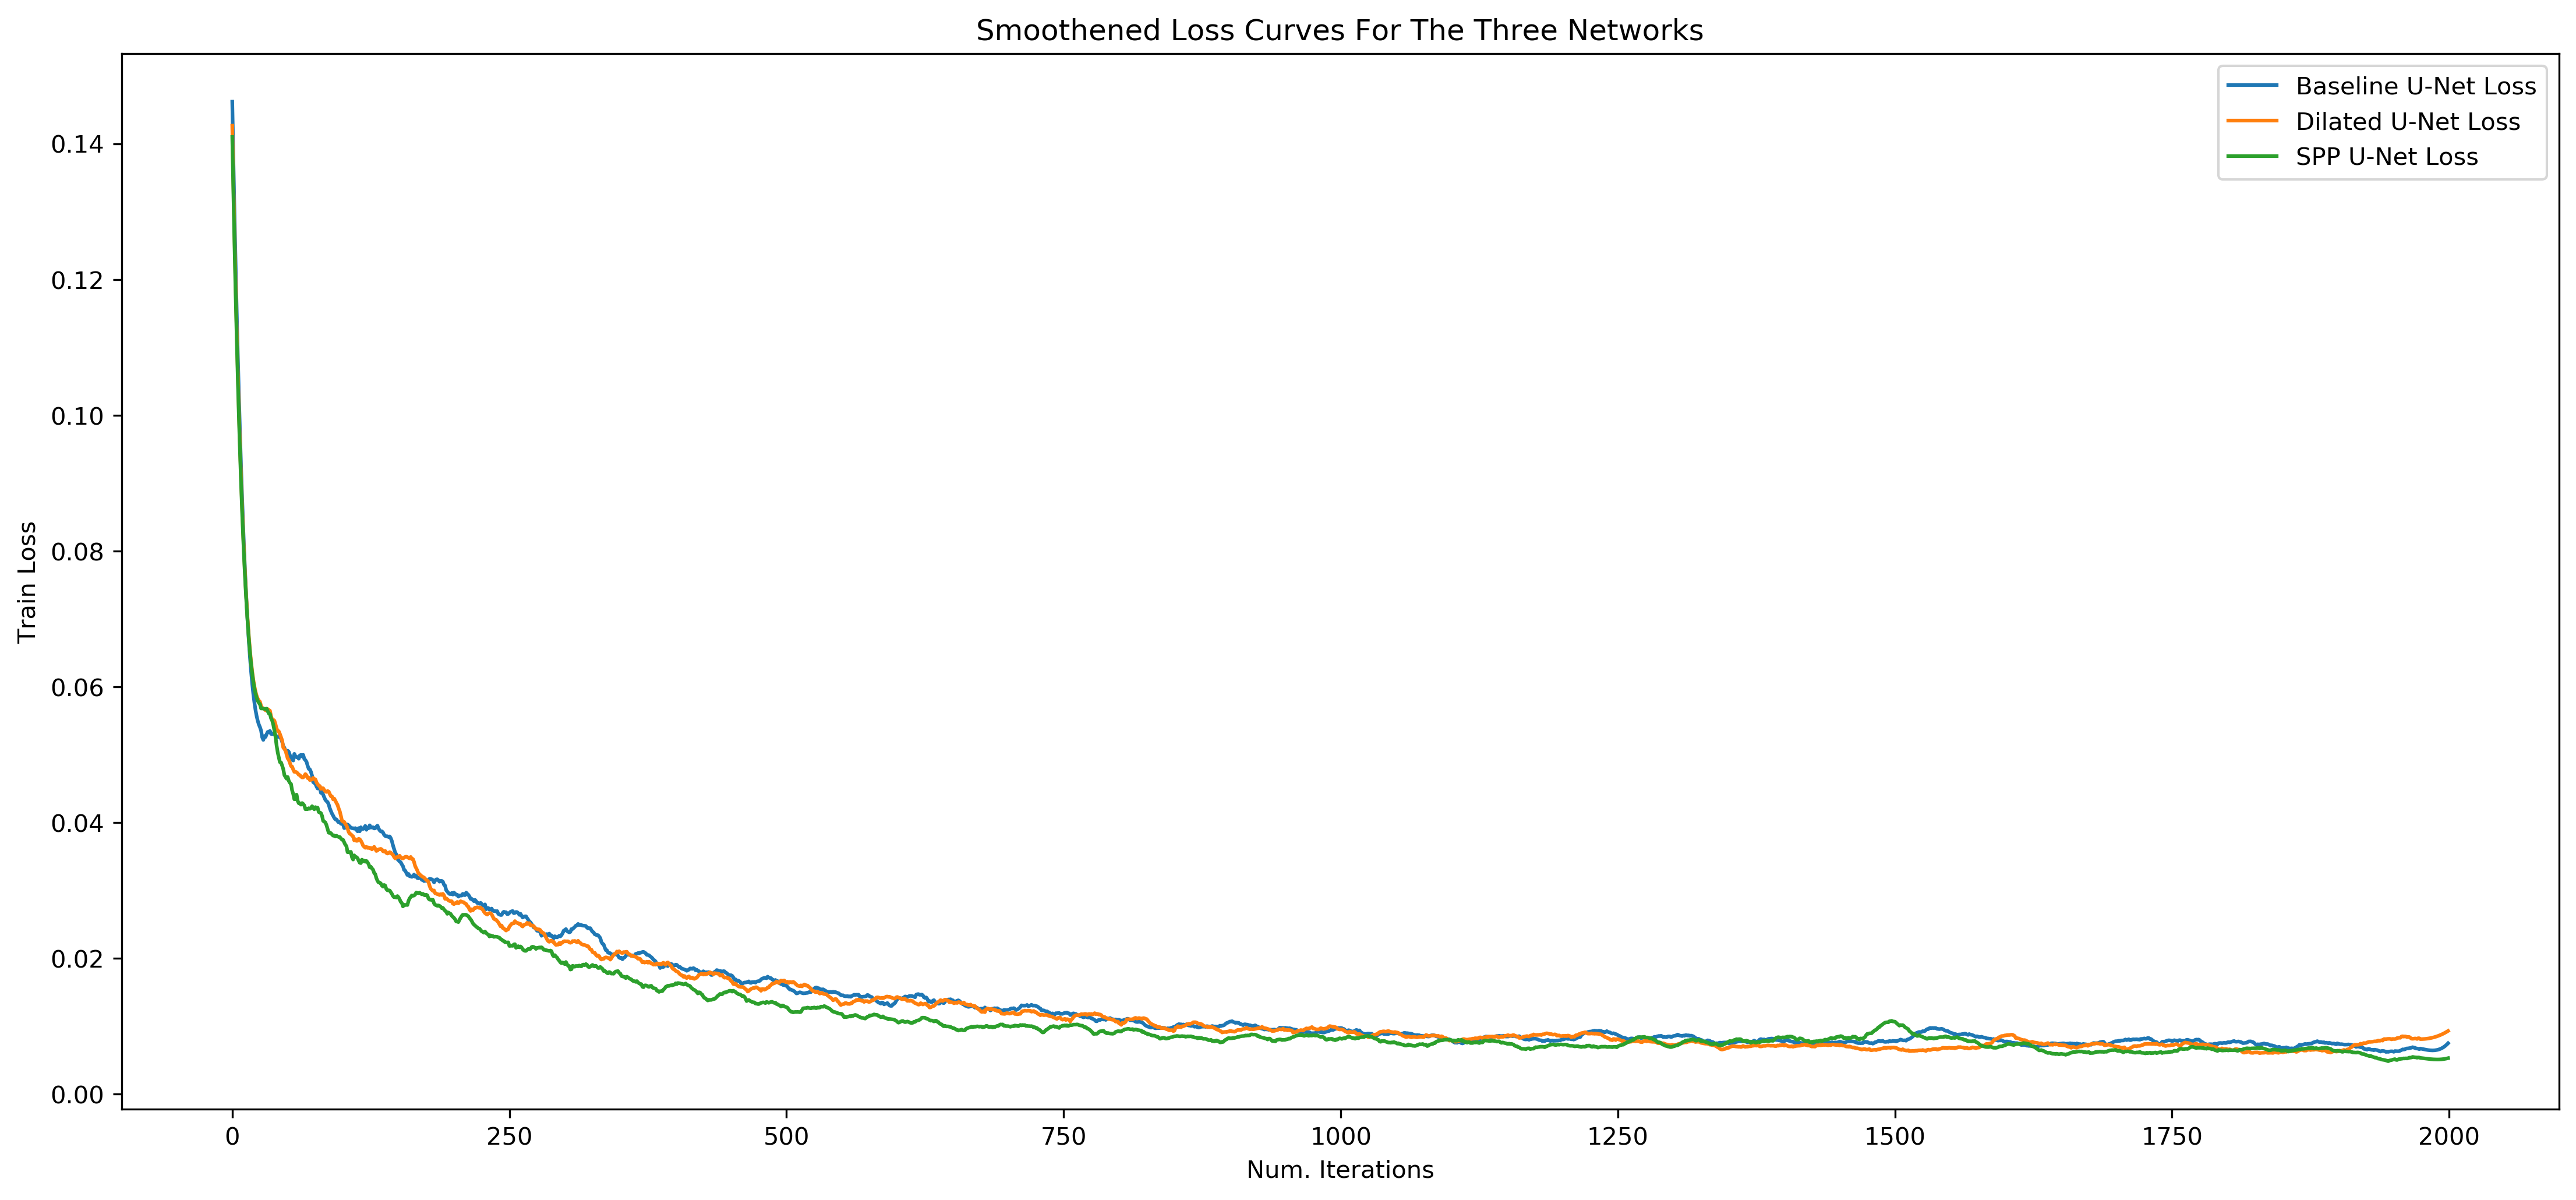

In [37]:
os.chdir('..')
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

%matplotlib inline
max_iter = 2000
baseline_loss = np.load('Segmentation/baseline/loss.npy')[:max_iter]
dilated_loss = np.load('Segmentation/train_dilation/loss.npy')[:max_iter]
spp_loss = np.load('Segmentation/train_spp/loss.npy')[:max_iter]
plt.figure(figsize=(18,8), dpi=300)
plt.plot(savgol_filter(baseline_loss, 51, 3), label='Baseline U-Net Loss')
plt.plot(savgol_filter(dilated_loss, 51, 3), label='Dilated U-Net Loss')
plt.plot(savgol_filter(spp_loss, 51, 3), label='SPP U-Net Loss')
plt.xlabel('Num. Iterations')
plt.ylabel('Train Loss')
plt.title('Smoothened Loss Curves For The Three Networks')
plt.legend();

D.

Note: I'm not sure where to find the names for the class labels so I'll use indices to represent the categories instead. Please don't dock points for this

In [9]:
# os.chdir('..')
import numpy as np
import pandas as pd
baseline = np.load('Segmentation/test_baseline/accuracy_44.npy')
dilated = np.load('Segmentation/test_2_dilation/accuracy_50.npy')
spp = np.load('Segmentation/test_2_spp/accuracy_44.npy')
df = pd.DataFrame([baseline, dilated, spp]).T
df.columns = ['baseline IoU', 'dilated IoU', 'spp IoU']
df.index.name = 'Category'
df

,baseline IoU,dilated IoU,spp IoU
Category,,,
0,87.806450,87.898857,90.316498
1,65.202087,49.381805,76.054352
2,41.823029,37.259354,34.881660
3,49.375084,52.385860,61.088215
4,39.172226,31.235426,49.153412
5,41.662563,44.798553,49.828247
6,55.186657,61.813770,73.941788
7,57.785835,50.037861,74.454247
8,51.517410,52.378468,66.133781


E.

In [73]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot(idxs):
#     baseline_idx = 1
#     dilated_idx = 4
#     spp_idx = 4
    _, ax = plt.subplots(len(idxs),3,figsize=(10,15))
    for i, idx_arr in enumerate(idxs):
        baseline_idx, dilated_idx, spp_idx = idx_arr
        img = Image.open(f'Segmentation/q14e_baseline/images_{baseline_idx}.png')

        baseline_overlay = Image.open(f'Segmentation/q14e_baseline/labelPred_{baseline_idx}.png')
        baseline_arr = np.asarray(Image.blend(img, baseline_overlay, 0.5))

        dilated_overlay = Image.open(f'Segmentation/q14e_dilation/labelPred_{dilated_idx}.png')
        dilated_arr = np.asarray(Image.blend(img, dilated_overlay, 0.5))

        spp_overlay = Image.open(f'Segmentation/q14e_spp/labelPred_{spp_idx}.png')
        spp_arr = np.asarray(Image.blend(img, spp_overlay, 0.5))

        ax[i,0].imshow(baseline_arr)
        ax[i,1].imshow(dilated_arr)
        ax[i,2].imshow(spp_arr)
        
        ax[i,0].set_title('Baseline U-Net')
        ax[i,1].set_title('Dilated U-Net')
        ax[i,2].set_title('SPP U-Net')

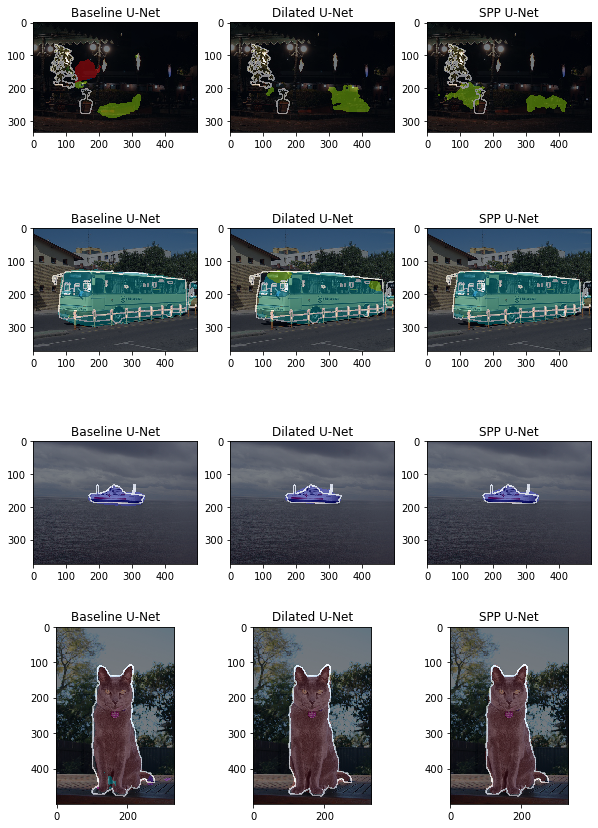

In [74]:
plot([[1,4,4],
      [2,1,3],
      [3,2,2],
      [4,3,1]])

This was the toughest image to segment which created the most significant differences among the three networks

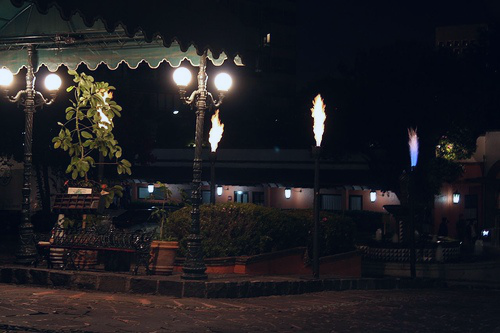

In [79]:
Image.open('Segmentation/q14e_baseline/images_1.png')

Now, let's look at the ground truth for reference. We have a tree and a pot.

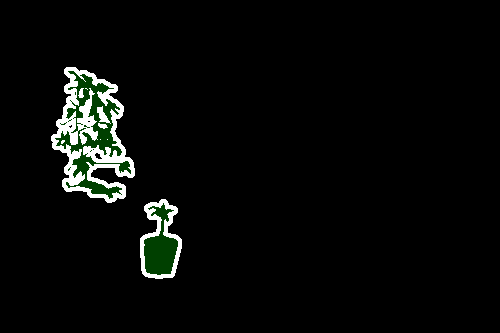

In [78]:
Image.open('Segmentation/q14e_baseline/labelGt_1.png')

**Some observations:**
- Overall, U-Net with Spatial Pyramid Pooling seems to give us the best results
- The differences in networks are dominated by blurred or occluded objects in the image. Some examples of this:
- In the cat image, the baseline U-net struggles with the gap between the cat's paws (as seen by the blue patch there). Both dilated and SPP U-Net don't have this problem.
- The first image is probably the most difficult of all to segment and here we can see a clear hierarchy of baseline < dilated < spp
- The baseline net thinks a dark patch in the background is an object. The dilated U-Net doesn't make the same mistake, but it is not able to get the bench in the bottom right while the SPP U-Net is able to pick it up much more accurately.
- For easy tasks like cat and boat, all networks perform similarly

F.

**Choices that helped to improve accuracy:**
- Implementing early stopping helped tremendously as all networks start to perform worse after training for more than 2000 iterations
- Using a learning rate scheduler like `ReduceLROnPlateau` also helped a ton with 
- Pyramid Pooling led to a noticeable improvement
- Adding dilation led to a very slight improvement

**Steps that could've been tried to improve accuracy:**
- I'm sure image augmentation would've helped tremendously
- Given a GPU with more VRAM, I'm sure larger batch sizes would help as I observed much better performance with `batch_size=64` compared to 32
- We could try to train an ensemble of U-Nets of varying depths instead of training only one (as proposed by Zhou et. al)
- We could try adding more bins to our pyramid pooling layer to give the network more context while training

## Q2: SSD [3] Object Detection

1. **Check the codes in `Detection`.** The codes are modified from ``https://github.com/amdegroot/ssd.pytorch``. Run `eval.py` code to get the object detection average precision (AP) on the PASCAL VOC 2012 dataset. The model is already trained on the PASCAL VOC 2012 object detection dataset and stored at ``/datasets/cs252-sp21-A00-public/hw3_data/detection/weights/VOC.pth``. Draw a table in your report summarizing the AP of all 20 object categories and their mean.   **[10 points]**

Results:

| object category | AP    |
| --------------- | ----- |
| aeroplane       | 0.782 |
| bicycle         | 0.720 |
| bird            | 0.648 |
| boat            | 0.465 |
| bottle          | 0.387 |
| bus             | 0.771 |
| car             | 0.685 |
| cat             | 0.826 |
| chair           | 0.457 |
| cow             | 0.648 |
| diningtable     | 0.557 |
| dog             | 0.780 |
| horse           | 0.726 |
| motorbike       | 0.772 |
| person          | 0.742 |
| pottedplant     | 0.349 |
| sheep           | 0.668 |
| sofa            | 0.587 |
| train           | 0.782 |
| tvmonitor       | 0.646 |
| **Mean AP**     | 0.650 |

2. **Answer the following questions:**
    1.  Briefly explain how average precision is computed for PASCAL VOC 2012 dataset. Please check the code ($\mathtt{eval.py:~Line~163-191}$). In this homework, we use the Pascal VOC 2007 metric. **[10 points]** 
    2. Explain how SSD can be much faster compared to Faster RCNN [4]? **[10 points]**
    3. Usually the number of negative bounding boxes (boxes without any object) is much larger than the number of positive bounding boxes. Explain how this imbalance is handled in SSD and Faster RCNN, respectively. **[10 points]**

A. How average precision is computed
- Average Precision is computed per class
- Next, we sort the bounding boxes in descending order of confidence
- For each bounding box, we compute the IoU with the ground truth
- Bounding boxes with >0.5 IoU considered TP else FP
- Using this we compute precision and recall using the general formulae for both
- Then we plot a PR curve and return the area under the PR curve

B. SSD can be much faster than Faster RCNN because:
- SSD does object detection in one step instead of two steps in Faster R-CNN
- SSD doesn't have a separate proposal generator network 
- SSD only does box classification and regression once vs twice in Faster R-CNN
- The trick SSD uses is extracting anchors at multiple scales using something called "default boxes"

C. How this imbalance is handled
- **SSD**: Sorts the examples using the highest confidence loss for each default box and picking the top ones so that the ration between negative and positive boxes is at most 3:1
- **Faster RCNN**: Boxes with IoU <= 0.3 are treated as background boxes and effectively ignored

3. Randomly pick up some images from the PASCAL VOC 2012 dataset and some from other sources. Visualize the bounding box prediction results and include a figure in your report. You can use the code in folder $\mathtt{demo}$ for visualization. **[10 points]**

In [13]:
os.chdir('Detection/')

In [29]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from ssd import build_ssd

!mkdir ../weights_local/
!cp /datasets/cse152-252-sp20-public/hw3_data/detection/weights/VOC.pth ../weights_local/
## or 
## git-lfs pull

net = build_ssd('test', 300, 21)    # initialize SSD
net.load_weights('../weights_local/VOC.pth');

# image = cv2.imread('./data/example.jpg', cv2.IMREAD_COLOR)  # uncomment if dataset not downloaded
%matplotlib inline
from matplotlib import pyplot as plt
from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform

def detect_objects(img_id, year='2012', name='val'):
    # here we specify year (07 or 12) and dataset ('test', 'val', 'train') 
    testset = VOCDetection(VOC_ROOT, [(year, name)], None, VOCAnnotationTransform())
    image = testset.pull_image(img_id)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # View the sampled input image before transform
    plt.figure(figsize=(10,10))

    x = cv2.resize(image, (300, 300)).astype(np.float32)
    x -= (104.0, 117.0, 123.0)
    x = x.astype(np.float32)
    x = x[:, :, ::-1].copy()
    # plt.imshow(x)
    x = torch.from_numpy(x).permute(2, 0, 1)

    xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
    if torch.cuda.is_available():
        xx = xx.cuda()
    y = net(xx)

    from data import VOC_CLASSES as labels
    top_k=10

    plt.figure(figsize=(10,10))
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    plt.imshow(rgb_image)  # plot the image for matplotlib
    currentAxis = plt.gca()

    detections = y.data
    # scale each detection back up to the image
    scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
    for i in range(detections.size(1)):
        j = 0
        while detections[0,i,j,0] >= 0.6:
            score = detections[0,i,j,0]
            label_name = labels[i-1]
            display_txt = '%s: %.2f'%(label_name, score)
            pt = (detections[0,i,j,1:]*scale).cpu().numpy()
            coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
            color = colors[i]
            currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
            currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
            j+=1

mkdir: cannot create directory ‘../weights_local/’: File exists
512
256
256
256
Loading weights into state dict...
Finished!


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


<Figure size 720x720 with 0 Axes>

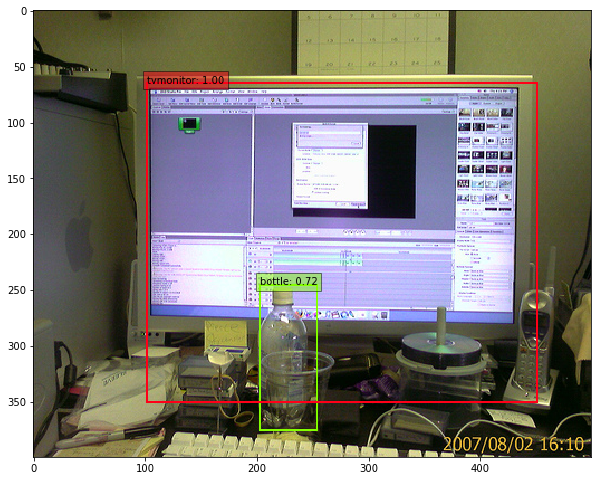

In [22]:
detect_objects(39)

/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


<Figure size 720x720 with 0 Axes>

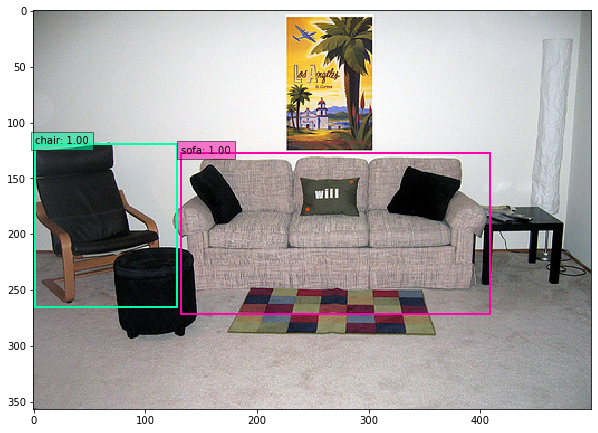

In [23]:
detect_objects(40)

/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


<Figure size 720x720 with 0 Axes>

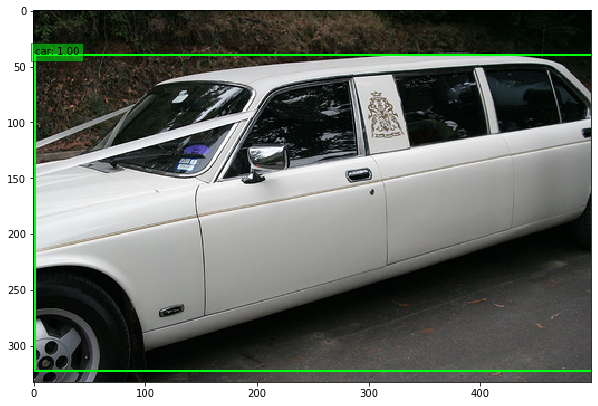

In [26]:
detect_objects(41)

/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


<Figure size 720x720 with 0 Axes>

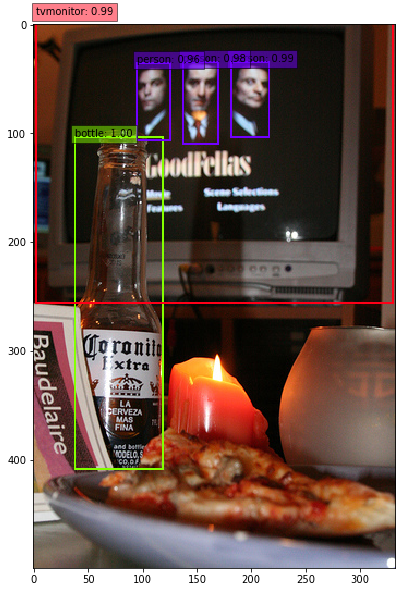

In [32]:
detect_objects(3, '2012', 'train')

/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


<Figure size 720x720 with 0 Axes>

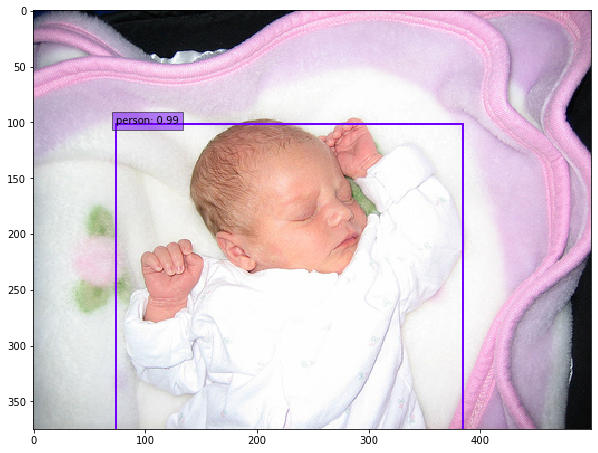

In [35]:
detect_objects(77, '2012', 'train')

## References
1. Yu, Fisher, and Vladlen Koltun. "Multi-scale context aggregation by dilated convolutions." arXiv preprint arXiv:1511.07122 (2015).
2. Zhao, Hengshuang, et al. "Pyramid scene parsing network." Proceedings of the IEEE conference on computer vision and pattern recognition. 2017.
3. Liu, Wei, et al. "Ssd: Single shot multibox detector." European conference on computer vision. Springer, Cham, 2016.
4.  Ren, Shaoqing, et al. "Faster r-cnn: Towards real-time object detection with region proposal networks." Advances in neural information processing systems. 2015.